In [1]:
import os
import gc
import time
import warnings
from datetime import datetime

from numba import njit, jit
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import iinfo, finfo, int8, int16, int32, int64, float32, float64

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras import callbacks
from tensorflow.keras import models
from tensorflow.keras import activations

from sklearn.model_selection import KFold
from sklearn.model_selection._split import _BaseKFold, indexable, _num_samples
from sklearn.utils.validation import _deprecate_positional_args

from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.io as pio
from IPython.display import HTML

# 设置plotly为暗黑模式
pio.templates.default = "plotly_dark"
plot_config = dict({'scrollZoom': True, 'displayModeBar': True, 'displaylogo': False})
sns.set(style="ticks", font_scale=1.2, palette='deep', color_codes=True)
colors = ["C" + str(i) for i in range(0, 9+1)]

# 默认plotly色号
default_color_list = [
    '#1f77b4',  # muted blue
    '#ff7f0e',  # safety orange
    '#2ca02c',  # cooked asparagus green
    '#d62728',  # brick red
    '#9467bd',  # muted purple
    '#8c564b',  # chestnut brown
    '#e377c2',  # raspberry yogurt pink
    '#7f7f7f',  # middle gray
    '#bcbd22',  # curry yellow-green
    '#17becf'   # blue-teal
    ]

# 设定全局随机种子，并且屏蔽warnings
GLOBAL_RANDOM_SEED = 2022
np.random.seed(GLOBAL_RANDOM_SEED)
tf.random.set_seed(GLOBAL_RANDOM_SEED)

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 50)


In [2]:
# 导入数据
load_data_start_time = time.time()
train_df  = pd.read_csv(
    './data/jane-street-market-prediction/train.csv', nrows=None)
feat_df = pd.read_csv(
    './data/jane-street-market-prediction/features.csv')
example_test_df = pd.read_csv(
    './data/jane-street-market-prediction/example_test.csv')
example_prediction_df = pd.read_csv(
    './data/jane-street-market-prediction/example_sample_submission.csv')
load_data_end_time = time.time()

# 打印数据基本情况
print("[INFO] {} End Reading ! It took {:.2f} seconds !".format(
    str(datetime.now())[:-4], load_data_end_time-load_data_start_time))
print("[INFO] {} Basic data description: ".format(str(datetime.now())[:-4]))
print("    -- train_df shape: {}".format(
    train_df.shape))
print("    -- example_test_df shape: {}".format(
    example_test_df.shape))
print("    -- feat_df shape: {}".format(
    feat_df.shape))
print("    -- example_prediction_df shape: {}".format(
    example_prediction_df.shape))

[INFO] 2021-01-07 20:26:01.67 End Reading ! It took 141.04 seconds !
[INFO] 2021-01-07 20:26:01.67 Basic data description: 
    -- train_df shape: (2390491, 138)
    -- example_test_df shape: (15219, 133)
    -- feat_df shape: (130, 30)
    -- example_prediction_df shape: (15219, 2)


In [10]:
# 挑选策略变化之后的数据
# train = train_df.query('date > 85').reset_index(drop=True)
train = train_df
train = train.query('weight > 0').reset_index(drop = True)

train["resp_target"] = (train["resp"] > 0.00001).astype(int)
for i in range(1, 4+1):
    train["resp_target_{}".format(i)] = (train["resp_{}".format(i)] > 0.00001).astype(int)

feature_name_list = [c for c in train.columns if 'feature' in c]
resp_name_list = ["resp", "resp_1", "resp_2", "resp_3", "resp_4"]

# 使用均值填充缺失值
mean_val_list = []
for name in feature_name_list:
    mean_val = train[name].mean()
    # train[name].fillna(mean_val, inplace=True)
    mean_val_list.append(mean_val)
mean_val_array = np.array(mean_val_list)


In [11]:
#######################################################################
# 数据基本信息，包括取值范围、分位数、unique的值等等。
#######################################################################
def basic_feature_report(data_table=None, precent=None):
    """针对data_table的每一列生成统计说明报告，包括分位数、缺失值等等。"""
    precent = precent or [0.01, 0.25, 0.5, 0.75, 0.95, 0.9995]
    if data_table is None:
        return None
    num_samples = len(data_table)

    # 基础统计信息
    basic_report = data_table.isnull().sum()
    basic_report = pd.DataFrame(basic_report, columns=["#missing"])
    basic_report["missing_precent %"] = basic_report["#missing"] / num_samples * 100
    basic_report["#uniques"] = data_table.nunique(dropna=False).values
    basic_report["types"] = data_table.dtypes.values
    basic_report.reset_index(inplace=True)
    basic_report.rename(columns={"index":"feature_name"}, inplace=True)

    # 基础分位数信息
    data_description = data_table.describe(precent).transpose()
    data_description.reset_index(inplace=True)
    data_description.rename(columns={"index":"feature_name"}, inplace=True)
    basic_report = pd.merge(basic_report, data_description,
        on='feature_name', how='left')
    return basic_report

train_report = basic_feature_report(train)
print("[INFO] {} Table report completed !".format(
    str(datetime.now())[:-4]))

[INFO] 2021-01-05 13:30:05.28 Table report completed !


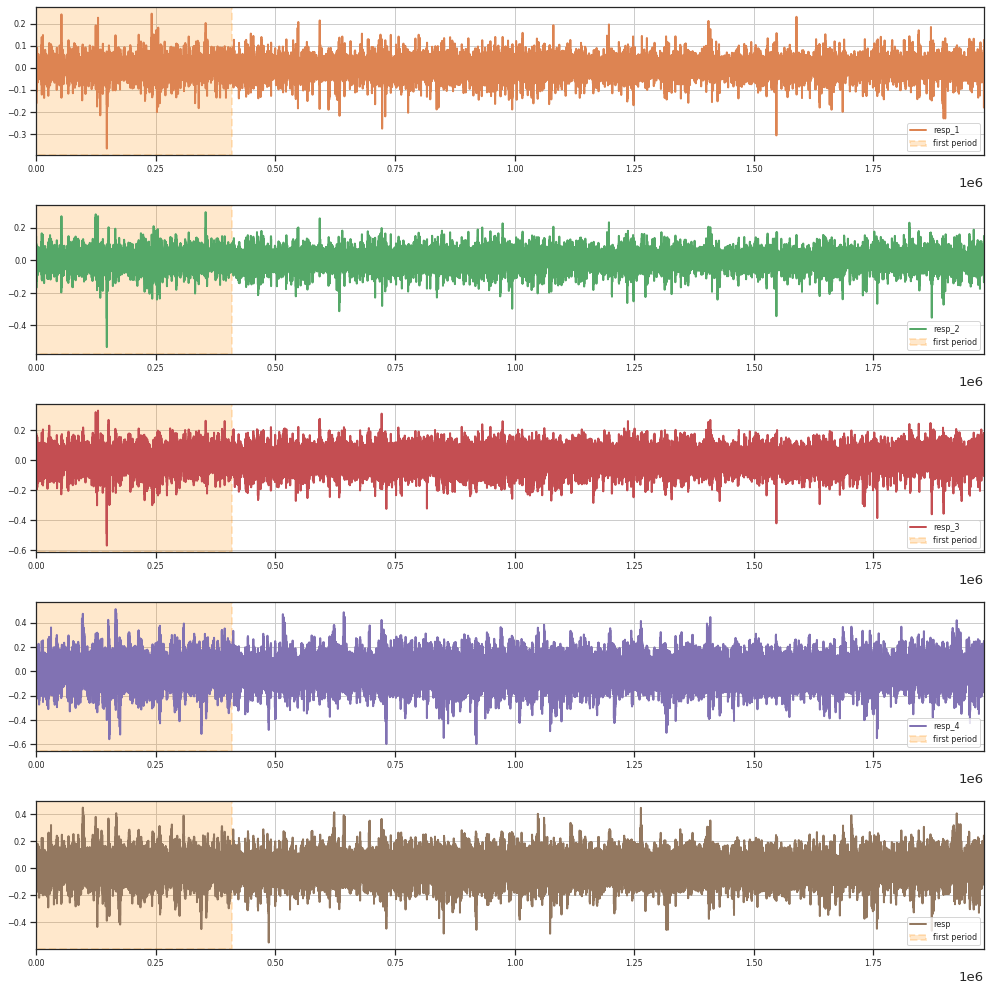

In [31]:
#######################################################################
# Resp的基础分析。
#######################################################################

# resp的取值分析
fig, ax_objs = plt.subplots(5, 1, figsize=(14, 14))
for i in range(1, 4+1):
    ax_objs[i-1].plot(train["resp_{}".format(i)].values, linewidth=2, color=colors[i],
                      linestyle="-", label="resp_{}".format(i))
ax_objs[-1].plot(train["resp"].values, linewidth=2, color=colors[i+1],
                 linestyle="-", label="resp")

change_point_id = np.min(list(train.query("date == 86").index))

for ax in ax_objs.ravel():
    ax.set_xlim(0, len(train))
    ax.axvspan(0, change_point_id, linestyle="--", label="first period",
               linewidth=2, color='darkorange', alpha=0.2)
    ax.tick_params(axis="both", labelsize=8)
    ax.grid(True)
    ax.legend(fontsize=8, loc='lower right')
plt.tight_layout()

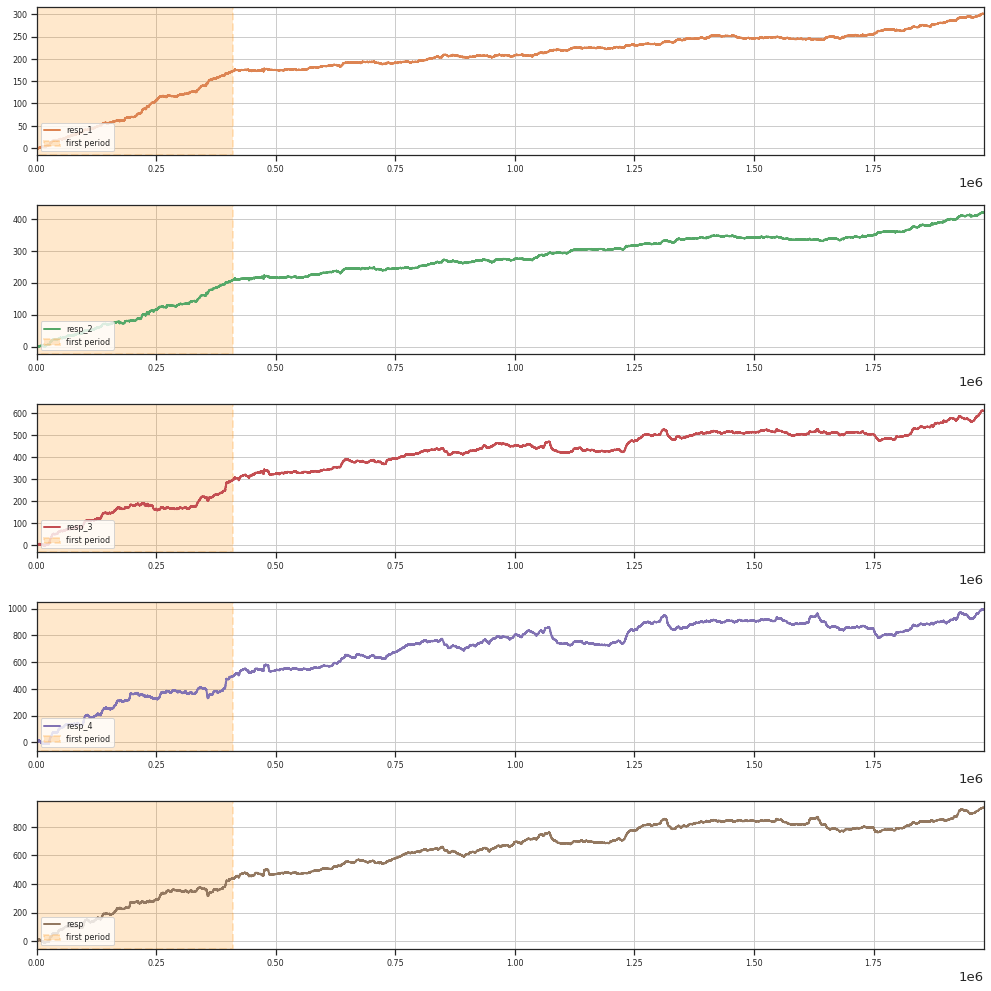

In [30]:
# resp的累计值分析

fig, ax_objs = plt.subplots(5, 1, figsize=(14, 14))
for i in range(1, 4+1):
    resp_tmp_val = train["resp_{}".format(i)].values
    resp_tmp_val = np.cumsum(resp_tmp_val)
    ax_objs[i-1].plot(resp_tmp_val, linewidth=2, color=colors[i],
                      linestyle="-", label="resp_{}".format(i))

resp_tmp_val = train["resp"].values
resp_tmp_val = np.cumsum(resp_tmp_val)
ax_objs[-1].plot(resp_tmp_val, linewidth=2, color=colors[i+1],
                 linestyle="-", label="resp")

change_point_id = np.min(list(train.query("date == 86").index))

for ax in ax_objs.ravel():
    ax.set_xlim(0, len(train))
    ax.axvspan(0, change_point_id, linestyle="--", label="first period",
               linewidth=2, color='darkorange', alpha=0.2)
    ax.tick_params(axis="both", labelsize=8)
    ax.grid(True)
    ax.legend(fontsize=8, loc='lower right')
plt.tight_layout()

In [ ]:
# resp标签分布分析

fig, ax_objs = plt.subplots(5, 1, figsize=(14, 14))
for i in range(1, 4+1):
    resp_tmp_val = train["resp_{}".format(i)].values



resp_tmp_val = train["resp"].values
resp_tmp_val = np.cumsum(resp_tmp_val)
ax_objs[-1].plot(resp_tmp_val, linewidth=2, color=colors[i+1],
                 linestyle="-", label="resp")
